# Data Exploration

In [1]:
import helper as hp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
train_X, test_X, train_y, test_y, test, labels, classes = hp.initData() #Getting test and train data

In [3]:
train_X, train_y = hp.augmentData(train_X, train_y)

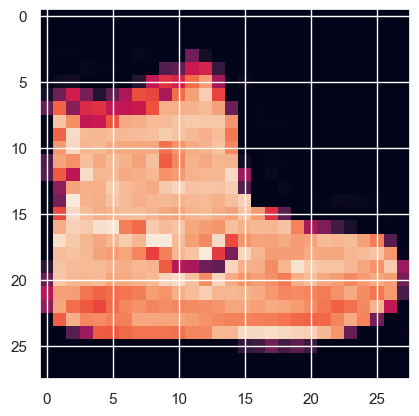

In [4]:
plt.imshow(train_X[50000])

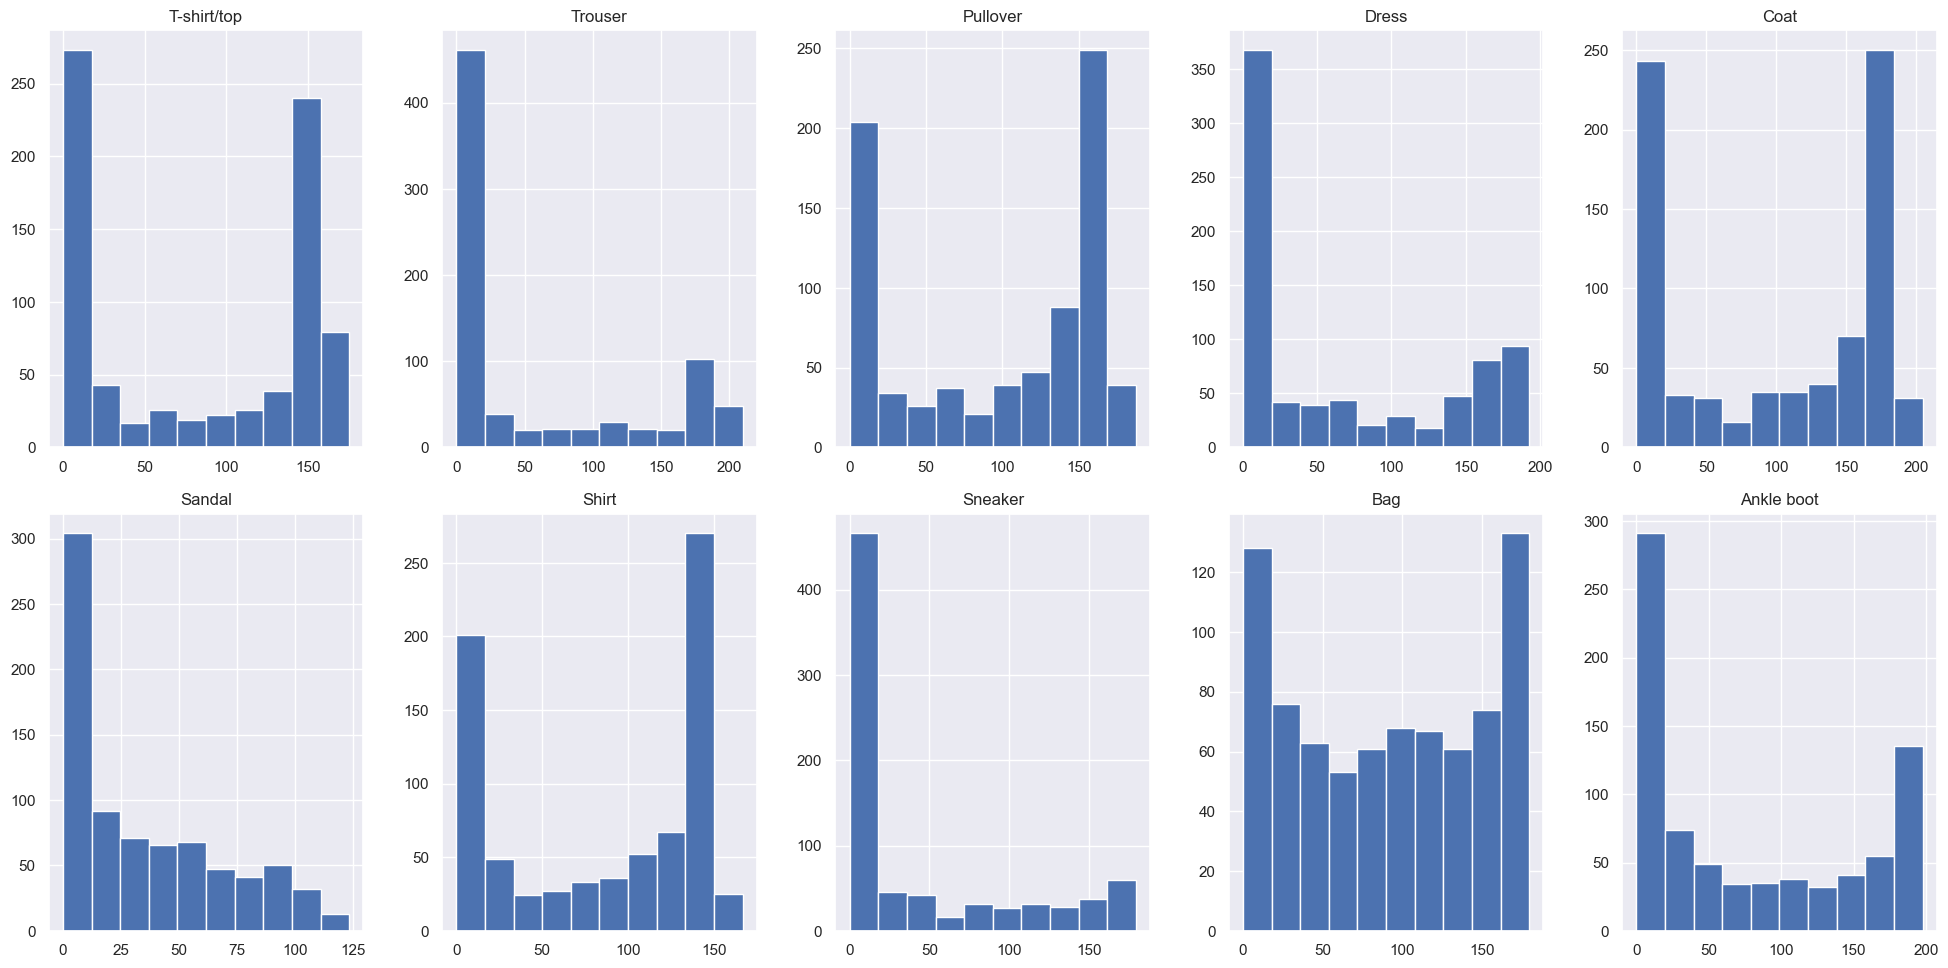

In [5]:
hp.dataDistribution(plot="intHist") 

Extra Analysis

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = np.load("./Data/train_images.npy")
data = data/255
data = data.reshape(data.shape[0], -1) 
labels = pd.read_csv("./Data/train_labels.csv").values

In [7]:
import umap
embedding = umap.UMAP().fit_transform(data, y=labels)

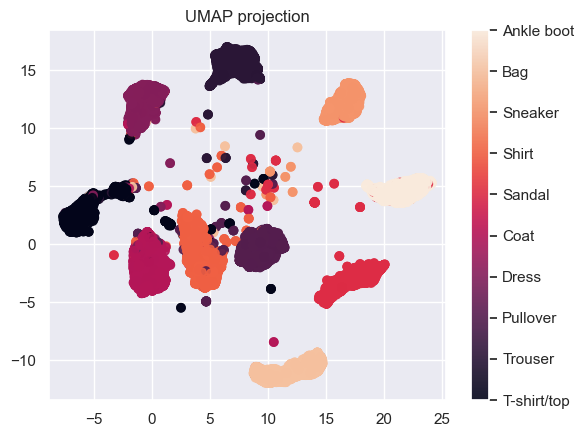

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, alpha=0.9)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(ticks=np.arange(10))
cbar.ax.set_yticklabels(classes)
plt.title('UMAP projection')
plt.show()

# Model Exploration

In [15]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras import Model

In [16]:
y_sparse_train = [[0 if train_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(train_y))]
y_sparse_train = np.array(y_sparse_train)
y_sparse_test = [[0 if test_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(test_y))]
y_sparse_test = np.array(y_sparse_test)

Base model (before enhancement)

In [18]:
callbackES = EarlyStopping(monitor="val_categorical_accuracy", patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dense(50, activation="relu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 43,096
Trainable params: 41,428
Non-traina

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [19]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0002), metrics=[CategoricalAccuracy(), AUC(), Precision(), Recall()])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=20)

Epoch 1/20
3125/3125 [==============================] - 9s 3ms/step - loss: 0.6154 - categorical_accuracy: 0.7917 - auc: 0.9781 - precision: 0.8612 - recall: 0.7229 - val_loss: 0.4520 - val_categorical_accuracy: 0.8416 - val_auc: 0.9875 - val_precision: 0.8764 - val_recall: 0.8043
Epoch 2/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.4432 - categorical_accuracy: 0.8451 - auc: 0.9879 - precision: 0.8825 - recall: 0.8088 - val_loss: 0.3967 - val_categorical_accuracy: 0.8566 - val_auc: 0.9899 - val_precision: 0.8882 - val_recall: 0.8317
Epoch 3/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.3987 - categorical_accuracy: 0.8598 - auc: 0.9899 - precision: 0.8900 - recall: 0.8299 - val_loss: 0.3714 - val_categorical_accuracy: 0.8680 - val_auc: 0.9909 - val_precision: 0.8934 - val_recall: 0.8464
Epoch 4/20
3125/3125 [==============================] - 8s 2ms/step - loss: 0.3710 - categorical_accuracy: 0.8683 - auc: 0.9911 - precision: 0.8957 - reca

In [20]:
model.save("./Model/FashionMNISTBase")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTBase\assets


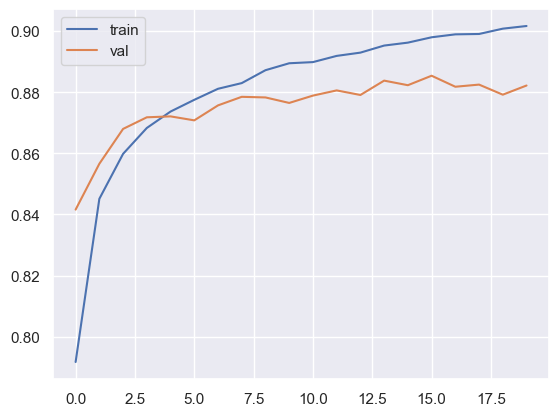

In [23]:
plt.plot(history.history["categorical_accuracy"], label="train")
plt.plot(history.history["val_categorical_accuracy"], label="val")
plt.legend()
plt.show()

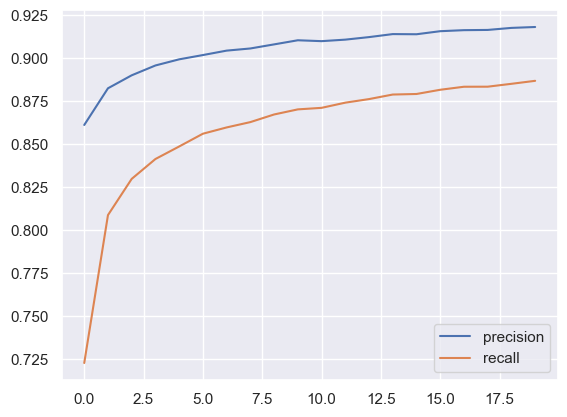

In [25]:
plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["recall"], label="recall")
plt.legend()
plt.show()

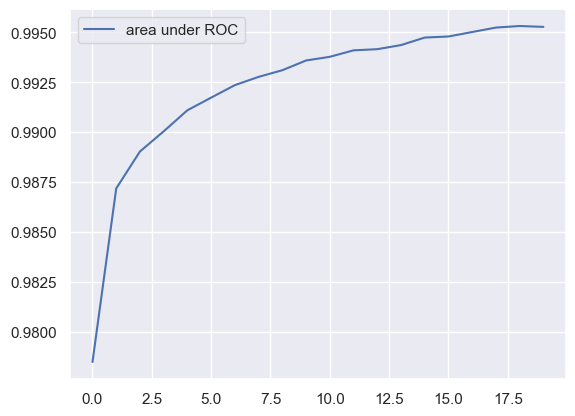

In [29]:
plt.plot(history.history["auc_2"], label="area under ROC")
plt.legend()
plt.show()

313/313 [==============================] - 0s 1ms/step


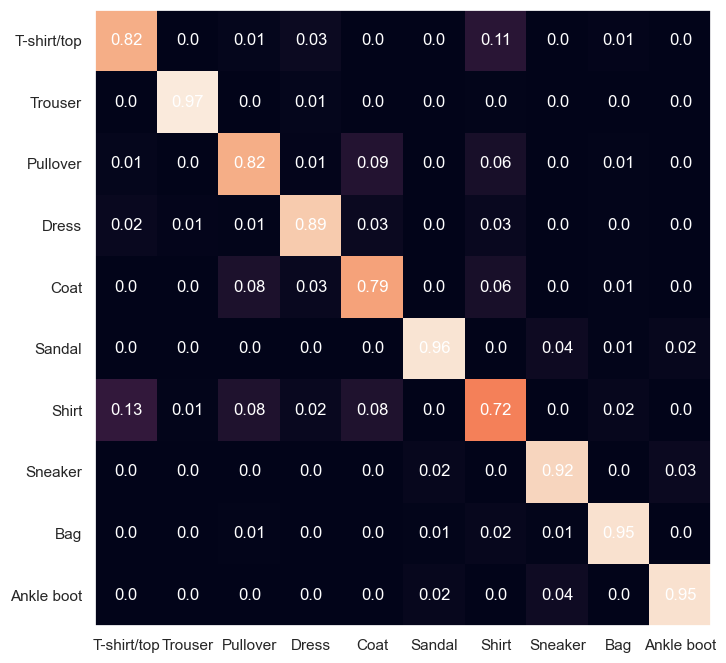

In [16]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(test_X)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(test_y, y_prediction, normalize='pred')

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(result)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
plt.grid(None)

# Loop over data dimensions and create text annotations.
for i in range(len(result)):
    for j in range(len(result)):
        text = ax.text(j, i, np.round(result[i, j],2),
                       ha="center", va="center", color="w")

In [17]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_prediction, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.852     0.836      1023
           1      0.975     0.981     0.978       988
           2      0.822     0.812     0.817      1008
           3      0.893     0.903     0.898      1021
           4      0.792     0.842     0.816      1050
           5      0.957     0.939     0.948       996
           6      0.719     0.630     0.671       970
           7      0.918     0.950     0.934       955
           8      0.952     0.956     0.954       968
           9      0.950     0.941     0.945      1021

    accuracy                          0.880     10000
   macro avg      0.880     0.881     0.880     10000
weighted avg      0.879     0.880     0.879     10000



# Model Enhancement

## Accuracy vs LR

La prueba se realizo dos veces para un ajuste mas fino del LR

In [121]:
model = load_model("./Model/FashionMNISTBase")
lr = 0.0000016
acc_valResults = []

for i in range(10):
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 32, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    lr = lr/5


Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2576 - accuracy: 0.9070 - val_loss: 0.3423 - val_accuracy: 0.8808
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2499 - accuracy: 0.9085 - val_loss: 0.3463 - val_accuracy: 0.8817
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2473 - accuracy: 0.9112 - val_loss: 0.3467 - val_accuracy: 0.8825
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9106 - val_loss: 0.3672 - val_accuracy: 0.8819
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2448 - accuracy: 0.9121 - val_loss: 0.3427 - val_accuracy: 0.8826
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2440 - accuracy: 0.9118 - val_loss: 0.3438 - val_accuracy: 0.8835
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2442 - accuracy: 0.9114 - val_loss: 0.3611 - val_accuracy:

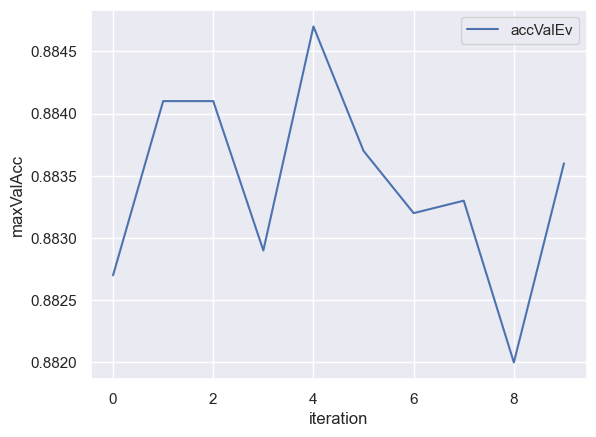

In [122]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Batchsize


In [134]:
bz = 32
acc_valResults = []

for i in range(5):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = bz, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    bz = bz*2

Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2638 - accuracy: 0.9051 - val_loss: 0.3458 - val_accuracy: 0.8823
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2567 - accuracy: 0.9078 - val_loss: 0.3463 - val_accuracy: 0.8824
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2581 - accuracy: 0.9062 - val_loss: 0.3385 - val_accuracy: 0.8831
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2569 - accuracy: 0.9084 - val_loss: 0.3397 - val_accuracy: 0.8830
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.3392 - val_accuracy: 0.8832
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2533 - accuracy: 0.9099 - val_loss: 0.3403 - val_accuracy: 0.8827
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2547 - accuracy: 0.9086 - val_loss: 0.3396 - val_accuracy:

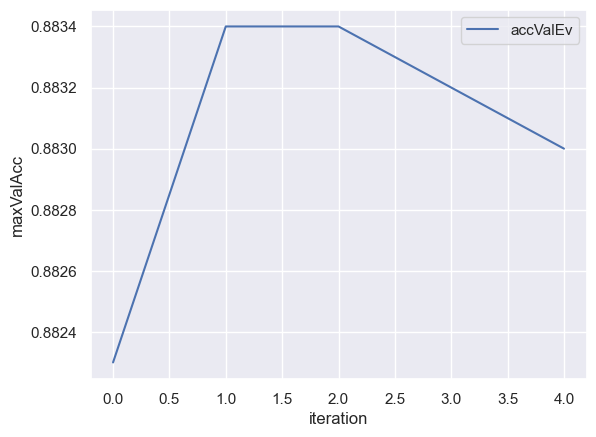

In [135]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

In [136]:
opts = [SGD(0.0000016), RMSprop(0.0000016), Adam(0.0000016), Adagrad(0.0000016)]
acc_valResults = []

for i in range(4):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=opts[i], metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 64, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2457 - accuracy: 0.9108 - val_loss: 0.3537 - val_accuracy: 0.8798
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3454 - val_accuracy: 0.8801
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3430 - val_accuracy: 0.8805
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2462 - accuracy: 0.9105 - val_loss: 0.3443 - val_accuracy: 0.8805
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2460 - accuracy: 0.9105 - val_loss: 0.3437 - val_accuracy: 0.8804
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.9111 - val_loss: 0.3427 - val_accuracy: 0.8806
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3431 - val_accuracy: 0.8812
Epoch 

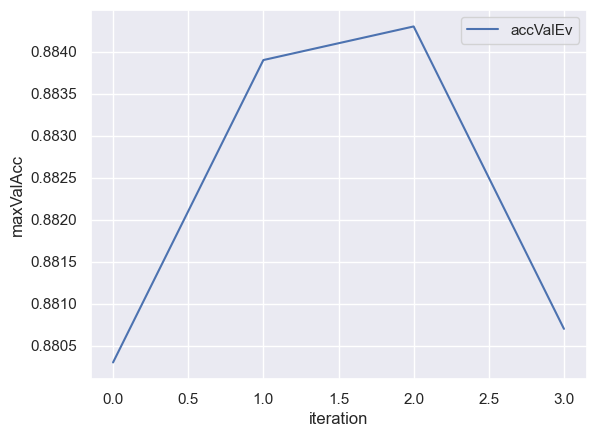

In [137]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## Accuracy vs Activations

In [153]:
activs = ["exponential","relu", "elu", "sigmoid", "tanh", "selu"]

for i in range(len(activs)):
    callbackES = EarlyStopping(monitor='accuracy', patience=3)
    initializer = GlorotNormal()
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(BatchNormalization())
    model.add(Dense(40, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 64, epochs=100)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/100
782/782 [==============================] - 4s 4ms/step - loss: 2.8342 - accuracy: 0.1132 - val_loss: 6.0838 - val_accuracy: 0.1407
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 2.5147 - accuracy: 0.1796 - val_loss: 8.7870 - val_accuracy: 0.2162
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 2.2484 - accuracy: 0.2506 - val_loss: 5.9614 - val_accuracy: 0.3128
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 2.0337 - accuracy: 0.3242 - val_loss: 4.8690 - val_accuracy: 0.3816
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 1.8732 - accuracy: 0.3796 - val_loss: 668.4653 - val_accuracy: 0.4229
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7445 - accuracy: 0.4277 - val_loss: 2.4605 - val_accuracy: 0.4649
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6435 - accuracy: 0.4660 - val_loss: 5.7447 - val_accuracy: 0.49

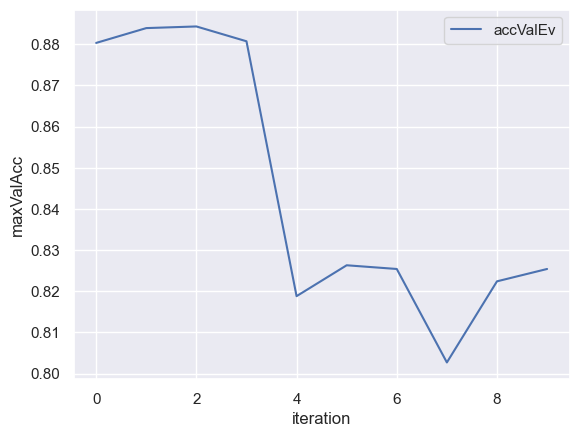

In [154]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

# Model Enhanced Analysis 

In [9]:
import tensorflow_addons as tfa
import tensorflow as tf

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
BATCH_SIZE = 128
INIT_LR = 0.0002
MAX_LR = 0.002

In [11]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      max_lr = MAX_LR)


callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [50]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
782/782 [==============================] - 5s 5ms/step - loss: 0.7400 - accuracy: 0.7458 - val_loss: 0.4875 - val_accuracy: 0.8261 - lr: 0.0011
Epoch 2/200
782/782 [==============================] - 4s 5ms/step - loss: 0.4786 - accuracy: 0.8302 - val_loss: 0.4171 - val_accuracy: 0.8523 - lr: 0.0020
Epoch 3/200
782/782 [==============================] - 4s 5ms/step - loss: 0.4166 - accuracy: 0.8503 - val_loss: 0.3747 - val_accuracy: 0.8663 - lr: 0.0011
Epoch 4/200
782/782 [==============================] - 4s 6ms/step - loss: 0.3794 - accuracy: 0.8625 - val_loss: 0.3578 - val_accuracy: 0.8710 - lr: 2.0173e-04
Epoch 5/200
782/782 [==============================] - 4s 5ms/step - loss: 0.3668 - accuracy: 0.8679 - val_loss: 0.3603 - val_accuracy: 0.8715 - lr: 6.5230e-04
Epoch 6/200
782/782 [==============================] - 4s 5ms/step - loss: 0.3677 - accuracy: 0.8662 - val_loss: 0.3559 - val_accuracy: 0.8692 - lr: 0.0011
Epoch 7/200
782/782 [==============================] - 4

In [51]:
model.save("./Model/FashionMNISTEnhanced")

INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


In [12]:
import pandas as pd
model = load_model("./Model/FashionMNISTEnhanced", compile=False)
toSubmit = pd.DataFrame(columns=["id","Category"])
toSubmit["id"] = np.arange(len(test))
toSubmit["Category"] = np.argmax(model.predict(test), (1))
toSubmit.to_csv("./Submit/sub1.csv", index=False)

313/313 [==============================] - 1s 1ms/step


## Aditionals

In [13]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      min_lr = MAX_LR)

callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(2, kernel_initializer=initializer, name='twinCity'))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout_2 (Dropout)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 twinCity (Dense)            (None, 2)                 202       
                                                                 
 dense_3 (Dense)             (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-trai

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
391/391 [==============================] - 3s 6ms/step - loss: 1.6985 - accuracy: 0.3301 - val_loss: 1.3231 - val_accuracy: 0.4695 - lr: 0.0011
Epoch 2/200
391/391 [==============================] - 2s 6ms/step - loss: 1.0091 - accuracy: 0.6260 - val_loss: 0.8564 - val_accuracy: 0.6919 - lr: 0.0020
Epoch 3/200
391/391 [==============================] - 2s 4ms/step - loss: 0.7705 - accuracy: 0.7565 - val_loss: 0.7040 - val_accuracy: 0.7851 - lr: 0.0011
Epoch 4/200
391/391 [==============================] - 2s 5ms/step - loss: 0.7013 - accuracy: 0.7822 - val_loss: 0.6636 - val_accuracy: 0.8030 - lr: 2.0346e-04
Epoch 5/200
391/391 [==============================] - 2s 5ms/step - loss: 0.6791 - accuracy: 0.7905 - val_loss: 0.6497 - val_accuracy: 0.8055 - lr: 6.5462e-04
Epoch 6/200
391/391 [==============================] - 2s 4ms/step - loss: 0.6597 - accuracy: 0.7929 - val_loss: 0.6216 - val_accuracy: 0.8143 - lr: 0.0011
Epoch 7/200
391/391 [==============================] - 2

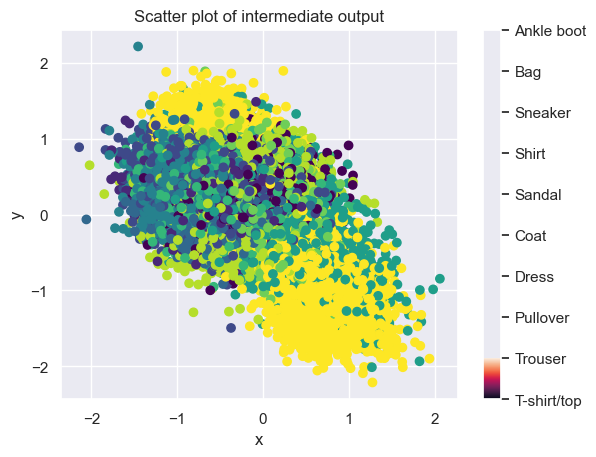

In [14]:
layer_name = 'twinCity'
intermediate_layer_model = Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(train_X)
# Extract the x and y coordinates of the intermediate output
x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

# Define a color map based on the values of train_y
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(train_y.min(), train_y.max())
colors = cmap(norm(train_y))

# Create the scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=colors)
cbar = fig.colorbar(scatter)
cbar.set_ticks(np.arange(0,len(classes)))
cbar.set_ticklabels(classes)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Scatter plot of intermediate output')
plt.show()